# Test rotation-modified KdV (Ostrovsky) equation

KdV 
$$
 \frac{\partial A}{\partial t} + c \frac{\partial A}{\partial x} + \alpha A \frac{\partial A}{\partial x} +\beta \frac{\partial^3 A}{\partial x^3} 
= 0
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iwaves.kdv.kdvcore import  KdVCore as KdV

In [2]:
##########
# Inputs
a0 = -25.
# nsteps = 19000
nsteps = 10000

N = 4000
dx = 50.
#ones = np.ones((N,))
ones = 1.

# Spatially-varying c
L = N*dx
c1 = 1.
c0 = 2.
x = np.arange(0,L,dx)
c = c0 - (c0-c1)/L*x

# Spatially-varying beta
L = N*dx
c1 = 2000.
c0 = 15000.
x = np.arange(0,L,dx)
beta = c0 - (c0-c1)/L*x

kdvargs = dict(
   N=N,
   c=c,
   alpha=-0.01*ones,
   beta=beta,
   dx=dx,
   dt=10.,
   spongedist = 20e3,
   spongetime = 360.,
   nonhydrostatic=1.,
   nonlinear=1.,
)


In [3]:
mykdv = KdV(**kdvargs)
print(mykdv.L_rhs.todense()[0:3,0:8])

[[ 1.20000000e-01 -3.79997500e-01  3.60000000e-01 -1.20000000e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.99950000e-02  1.20000000e-01 -3.79995000e-01  3.60000000e-01
  -1.20000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.99480000e-02 -9.99295000e-02 -2.54432061e-29  9.99295000e-02
  -5.99480000e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00]]


In [4]:
def bcfunc2(a0,t):
    t0 = 3*3600
    T = 1*3600
    return a0*np.exp(-((t - t0)/T)**2.)

def bcfunc(a0,t):
    T = 6*3600
    omega = 2*np.pi/T
    return a0*np.sin(omega*t)


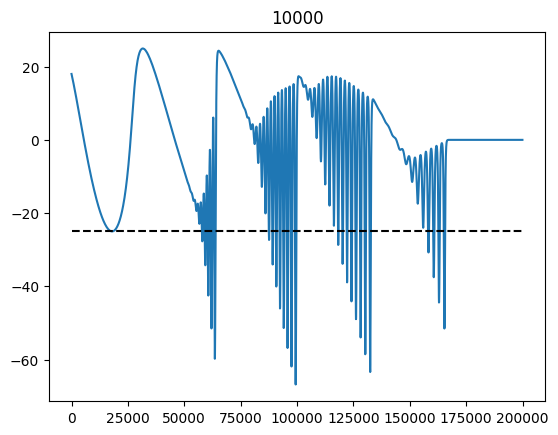

In [5]:
for ii in range(nsteps):
    if mykdv.solve_step(bc_left=bcfunc(a0,mykdv.t)) != 0:
        print('Blowing up at step: %d'%ii)
        break

plt.figure()
plt.plot(x,mykdv.B_n_p1)
plt.plot([x[0],x[-1]],[a0,a0],'k--')
plt.title(nsteps)
plt.show()

Holloway 1999
$$
\frac{\partial}{\partial x}\left( \frac{\partial A}{\partial t} + c \frac{\partial A}{\partial x} + \alpha A \frac{\partial A}{\partial x} +\beta \frac{\partial^3 A}{\partial x^3} \right)
= \frac{f^2}{2c}A
$$

Ostrovsky equation
$$
 \frac{\partial A}{\partial t} + c \frac{\partial A}{\partial x} + \alpha A \frac{\partial A}{\partial x} +\beta \frac{\partial^3 A}{\partial x^3} 
= \int_{-\infty}^{x}\frac{f^2}{2c}A\ dx'
$$

Obregon and Stepanyants 2012 equation
$$
 \frac{\partial A}{\partial t} + c \frac{\partial A}{\partial x} + \alpha A \frac{\partial A}{\partial x} +\beta \frac{\partial^3 A}{\partial x^3} 
= \frac{f^2}{2c}\left[ v(x,t) -\langle v \rangle \right]
$$
where
$$v(x,t)=\int_{0}^{x} A(x',t)\ dx'$$
and
$$
\langle v \rangle = \frac{1}{L}\int_{0}^{L} v(x,t)\ dx
$$

In [12]:
class rKdV1(KdV):
    def __init__(self, cor_f=0, **kwargs):
        self.cor_f = cor_f
        KdV.__init__(self, **kwargs)

    def calc_nonlinear_rhs(self, A):
        """
        Calculate the nonlinear steepening term vectors
        """
        rhs = KdV.calc_nonlinear_rhs(self, A)

        cff = 0.5*self.cor_f*self.cor_f / self.c 

        rhs -= np.cumsum(cff * A * self.dx)
        
        return rhs
        
class rKdV(KdV):
    def __init__(self, cor_f=0, **kwargs):
        self.cor_f = cor_f
        KdV.__init__(self, **kwargs)

    def calc_nonlinear_rhs(self, A):
        """
        Calculate the nonlinear steepening term vectors
        """
        rhs = KdV.calc_nonlinear_rhs(self, A)

        cff = 0.5*self.cor_f*self.cor_f / self.c 

        #rhs -= np.cumsum(cff * A * self.dx)
        v = np.cumsum(A) * self.dx
        L = self.N *  self.dx
        v_bar = np.sum(v)/L
        rhs -= cff*(v-v_bar)

        return rhs

In [14]:
cor_f = 5e-5
myrkdv = rKdV(cor_f=cor_f, **kdvargs)

for ii in range(nsteps):
    if myrkdv.solve_step(bc_left=bcfunc(a0,myrkdv.t)) != 0:
        print('Blowing up at step: %d'%ii)
        break

# First try
cor_f = 5e-5
myrkdv1 = rKdV1(cor_f=cor_f, **kdvargs)

for ii in range(nsteps):
    if myrkdv1.solve_step(bc_left=bcfunc(a0,myrkdv1.t)) != 0:
        print('Blowing up at step: %d'%ii)
        break

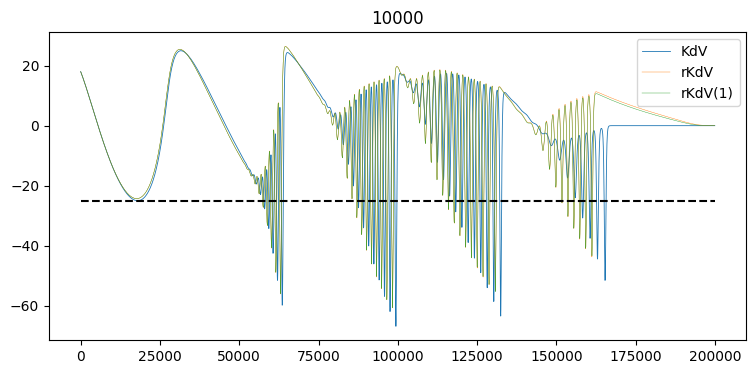

In [15]:
plt.figure(figsize=(9,4))
plt.plot(x,mykdv.B_n_p1, lw=0.6)
plt.plot(x,myrkdv.B_n_p1, lw=0.3)
plt.plot(x,myrkdv1.B_n_p1, lw=0.3)

plt.legend(('KdV','rKdV','rKdV(1)'))
plt.plot([x[0],x[-1]],[a0,a0],'k--')
plt.title(nsteps)
plt.show()

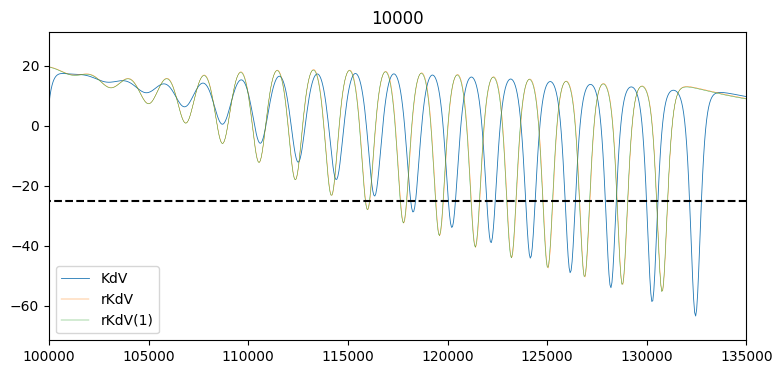

In [16]:
plt.figure(figsize=(9,4))
plt.plot(x,mykdv.B_n_p1, lw=0.6)
plt.plot(x,myrkdv.B_n_p1, lw=0.3)
plt.plot(x,myrkdv1.B_n_p1, lw=0.3)

plt.legend(('KdV','rKdV','rKdV(1)'))
plt.plot([x[0],x[-1]],[a0,a0],'k--')
plt.title(nsteps)
plt.xlim(1e5,1.35e5)
plt.show()